<style>
h1 {text-align: center; font-family: Georgia; font-size: 36px; font-weight: bold; line-height: 48px}
h2 {font-family: Calisto MT; font-size: 30px; font-weight: bold; color: #6a085c}
h3 {font-family: Lucida Bright; font-size: 24px; font-weight: bold; color: #114a4f}
h4 {text-indent: 2em; font-family: Cambria; font-size: 18px}
p.text {text-indent: 2em; text-align: justify; font-family: Times New Roman; font-size: 20px}
p.ex {text-align: center; font-family: Times New Roman; font-size: 20px}
table.t {width: 80%; border: 1px solid; padding: 5px; border-collapse: collapse}
th.h {text-align: left; font-family: Georgia; font-size: 18px; border: 1px solid; padding: 5px}
td.d {text-align: left; font-family: Cambria; font-size: 18px; border: 1px solid; padding: 5px}
code {font-family: monospace; font-weight: bold; font-size: 16px; color: crimson; padding: 4px}
</style>

<h1>Formalizing Informal Text using Natural Language Processing</h1>

<h2>1. Overview:</h2>

<h3>1.1. Introduction:</h3>
<p class = "text">
English is a funny language, they say. While it may be, for non native speakers, learning english has always been a really challenging task. They find it difficult to comprehend the nuances and subtleties which are so obvious to native speakers. The crux of any language stems from it’s grammar, and obscurity of english grammar doesn’t help either in understanding the language. However, things are changing. Globalization certainly influenced non native speakers to improve their english proficiency by watching movies, reading books or listening to news and sports commentaries. As far as informal conversations, messages or tweets are
concerned, they don’t have any problems with that. However, formal English where grammar intricacies are involved still perplexes them. This case study is an attempt to design a system which can convert informal english text into formal english text using Natural Language Processing techniques.
</p>

<h3>1.2. Business Problem:</h3>
<p class = "text">
The system should be able to generate text in formal english, given it’s
informal form. Informal text can be anything ranging from a random tweet to
comic extract. The formal text should have syntactically correct meaning as
intended by its informal counterpart. It should be able to correct grammar,
punctuations and if possible, even capitalisations. For instance,

<p class = "ex">
<strong>Informal input :</strong> what r ya talking abt
</p>
<p class = "ex">
<strong>Formal input :</strong> What are you talking about?
</p>
</p>

<h3>1.3. Business Constraints:</h3>
<p class = "text">
The informal text refers to the text with a lot of abbreviations and
misspelled words. Hence, it is imperative for the system to correct these
words. The system should be able to generate the text in real-time given its
informal form to avoid latency problems. Also, in trying to generate
grammatically correct text, it should not change the meaning of the
underlying text as it might be counterproductive to the task at hand.
</p>

<h3>1.4. Dataset:</h3>
<p class = "text">
There is a real scarcity of the publicly available normalized datasets.
Fortunately, NUS Social Media Text Normalization and Translation Corpus
can be used for this case study. The corpus is created for social media text
normalization and translation. It is built by randomly selecting 2,000
messages from the NUS English SMS corpus. The messages were first
normalized into formal English and then translated into formal Chinese
which we can ignore.
Corpus is available for download</p>
<a href = "http://www.comp.nus.edu.sg/~nlp/sw/sm_norm_mt.tar.gz">here</a>

<h2>2. Data Preprocessing:</h2>
<h3>2.1. Dataset:</h3>
<p class = "text">
We will now import required libraries and load the dataset.
</p>

In [1]:
import re
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
import warnings
warnings.filterwarnings("ignore")

<h3>2.2. Loading data:</h3>
<p class = "text">
The dataset is structured as informal text followed by its formal correction and then Chinese translation each on a new line. We will make a pandas DataFrame with two columns namely Informal text and Formal text by reading the text file of the data. As the text is collected from messages and general conversations, we will preserve the case, punctuations, and stopwords.
</p>

In [4]:
# Reading the file
f = open("en2cn-2k.en2nen2cn", "r", encoding = 'utf-8')
text = f.read()
# Removing last instance after splitting as it is empty string
text = text.split('\n')[:-1]
# Creating the pandas dataframe
data = [[text[i], text[i+1]] for i in list(range(0, 6000, 3))]
df = pd.DataFrame(data, columns = ['Informal text', 'Formal text'])
df.head()

,Informal text,Formal text
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


<p class = "text">
The model we will design is known as a sequence-to-sequence model as we are providing a text sequence as input and expect the text sequence as output. Speaking of sequence-to-sequence models, two distinctions based on the level of tokenization can be made viz. word level and character level. On experimenting with both types of tokenizations, we find that the character level tokenizer achieves much better results which are to be expected given the size of the dataset, hence we will focus on the same in this case study.
</p>

In [5]:
# Creating encoder inp, decoder inp and decoder_out 
encoder_inp = '<' + df['Informal text'].astype(str) + '>'
decoder_inp = '<' + df['Formal text'].astype(str)
decoder_out = df['Formal text'].astype(str) + '>'
# Creating the dataframe
preprocessed_data = pd.DataFrame()
preprocessed_data['encoder_inp'] = encoder_inp
preprocessed_data['decoder_inp'] = decoder_inp
preprocessed_data['decoder_out'] = decoder_out
preprocessed_data.head()

,encoder_inp,decoder_inp,decoder_out
0,"<U wan me to ""chop"" seat 4 u nt?>",<Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not?>
1,<Yup. U reaching. We order some durian pastry ...,<Yeap. You reaching? We ordered some Durian pa...,Yeap. You reaching? We ordered some Durian pas...
2,<They become more ex oredi... Mine is like 25....,<They become more expensive already. Mine is l...,They become more expensive already. Mine is li...
3,<I'm thai. what do u do?>,<I'm Thai. What do you do?,I'm Thai. What do you do?>
4,<Hi! How did your week go? Haven heard from yo...,<Hi! How did your week go? Haven't heard from ...,Hi! How did your week go? Haven't heard from y...


<h3>2.3. Splitting the data into training and validation sets:</h3>
<p class = "text">
Before we split the data, we will look at the distribution of lengths of encoder inp, decoder inp and decoder_out to get the idea of input shape we will need to embed our data into.
</p>

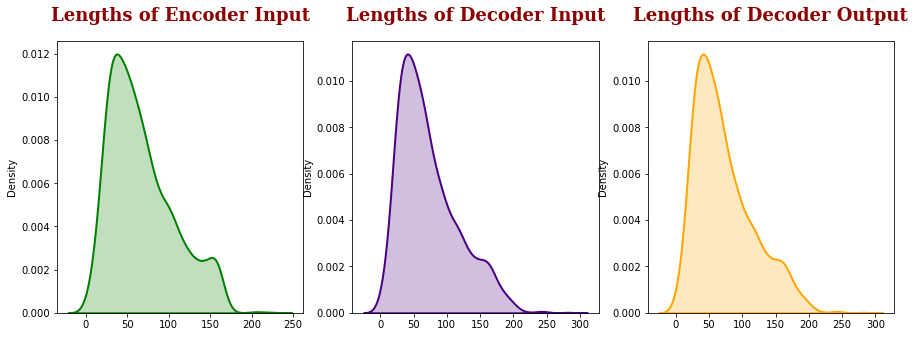

In [7]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 3)

# plotting the distributions
sns.distplot(preprocessed_data['encoder_inp'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green", ax = ax[0])
sns.distplot(preprocessed_data['decoder_inp'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "indigo", ax = ax[1])
sns.distplot(preprocessed_data['decoder_out'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "orange", ax = ax[2])

# adding titles to the subplots
ax[0].set_title("Lengths of Encoder Input", fontdict = title_font, pad = 20.0)
ax[1].set_title("Lengths of Decoder Input", fontdict = title_font, pad = 20.0)
ax[2].set_title("Lengths of Decoder Output", fontdict = title_font, pad = 20.0)

# rescaling the figure
fig.set_figheight(5)
fig.set_figwidth(15)

<p class = "text">
As we can see, most of the sentences are of length around 50 and almost all the sentences have lengths less than 40. Hence, we can filter out the sentences which are of length more than 200.
</p>

In [8]:
# Filtering out sentences of length more than 200
preprocessed_data = preprocessed_data[preprocessed_data['encoder_inp'].str.split().apply(len) <= 200]
preprocessed_data = preprocessed_data[preprocessed_data['decoder_inp'].str.split().apply(len) <= 200]
preprocessed_data = preprocessed_data[preprocessed_data['decoder_out'].str.split().apply(len) <= 200]
preprocessed_data.head()

,encoder_inp,decoder_inp,decoder_out
0,"<U wan me to ""chop"" seat 4 u nt?>",<Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not?>
1,<Yup. U reaching. We order some durian pastry ...,<Yeap. You reaching? We ordered some Durian pa...,Yeap. You reaching? We ordered some Durian pas...
2,<They become more ex oredi... Mine is like 25....,<They become more expensive already. Mine is l...,They become more expensive already. Mine is li...
3,<I'm thai. what do u do?>,<I'm Thai. What do you do?,I'm Thai. What do you do?>
4,<Hi! How did your week go? Haven heard from yo...,<Hi! How did your week go? Haven't heard from ...,Hi! How did your week go? Haven't heard from y...


<p class = "text">
We can now split the data into train, validation and test sets. As we have less data, we will split with about 90:05:05 split to use more data to train the model.
</p>

In [9]:
train, validation = train_test_split(preprocessed_data, test_size=0.05, random_state = 859)
train, test = train_test_split(train, test_size=0.05, random_state = 859)
joblib.dump(train, 'train.pkl')
joblib.dump(validation, 'validation.pkl')
joblib.dump(test, 'test.pkl')
print(f"Shape of Training set: {train.shape}")
print(f"Shape of Validation set: {validation.shape}")
print(f"Shape of Test set: {test.shape}")
# for one sentence we will be adding '>' token so that the tokanizer learns the word '>'
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['encoder_inp']= str(train.iloc[0]['encoder_inp']) + '>'

Shape of Training set: (1805, 3)
Shape of Validation set: (100, 3)
Shape of Test set: (95, 3)


<h3>2.4. Tokenizing data:</h3>
<p class = "text">
Tokenizing the data means, encoding the sentences with numbers. The numbers are assigned by an unique id from the vocabulary. So, the particular sentence will be encoded by unique ids of words occuring in that sentence. We will create the two tokenizers each for informal and formal data.
</p>

In [11]:
# Tokenizing informal data with case preservation and excluding common punctuations like .,?!:;
tknizer_informal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
tknizer_informal.fit_on_texts(train['encoder_inp'].values)
joblib.dump(tknizer_informal, 'tknizer_informal.pkl')
# Tokenizing formal data with case preservation and excluding common punctuations like .,?!:;
tknizer_formal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
# Introducing '<end>' token on first sentence so that vocabulary learns it
train['decoder_inp'].iloc[0] = train['decoder_inp'].iloc[0] + '>'
tknizer_formal.fit_on_texts(train['decoder_inp'].values)
joblib.dump(tknizer_formal, 'tknizer_formal.pkl')
# Printing sizes of vocabularies
vocab_size_informal = len(tknizer_informal.word_index.keys())
print(f"Vocab size of Informal text: {vocab_size_informal}")
vocab_size_formal = len(tknizer_formal.word_index.keys())
print(f"Vocab size of Formal text: {vocab_size_formal}")

Vocab size of Informal text: 103
Vocab size of Formal text: 91


<h3>2.4. Padding data:</h3>
<p class = "text">
Padding refers to appending a common id (i.e. generally 0) to make all the sentences of same length. As we saw earlier, we can make the sentence lengths as 200.
</p>

In [12]:
# Encoding the sentences by numerical ids in place of words
encoder_seq = tknizer_informal.texts_to_sequences(train['encoder_inp'].values)
decoder_inp_seq = tknizer_formal.texts_to_sequences(train['decoder_inp'].values)
decoder_out_seq = tknizer_formal.texts_to_sequences(train['decoder_out'].values)
# Padding the sentences to make all the sentences of same length
encoder_seq = pad_sequences(encoder_seq, maxlen = 40, dtype='int32', padding='post')
decoder_inp_seq = pad_sequences(decoder_inp_seq, maxlen = 40, dtype='int32', padding='post')
decoder_out_seq = pad_sequences(decoder_out_seq, maxlen = 40, dtype='int32', padding='post')

<p class = "text">
We now have preprocessed data which we can use to train the models.
</p>